In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import torch
import gymnasium as gym
import gym_bart
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import forced_action_evaluate
from model_evaluation import bart_toggle_data_callback, meta_bart_callback
from bart_behavior_analysis import (
    color_to_idx, 
    idx_to_color, 
    bart_plot_colors,
    plot_bart_behaviors,
    get_bart_res_eps,
    get_meta_mean_diffs,
    get_meta_self_mean_diff,
    get_pop_rates,
    plot_3color_it_rt,
    plot_3color_meta_ep,
    plot_ncolor_meta_ep,
    plot_ncolor_meta_progression,
    plot_meta_it_progression,
    plot_1color5fsize,
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

set_rc()
# evalu = partial(forced_action_evaluate, data_callback=bart_toggle_data_callback,
#                 env_name="BartEnv-v0", num_episodes=100)

In [136]:


all_data = pickle.load(open('data/meta1c_progressive_pop_rates', 'rb'))

In [132]:
def classify_metabart_behavior(pop_rate, max_mean):
    '''
    Based on test mus of np.arange(0.2, 1.01, 0.05),
    Classify whether an agent has
        non_performant: fixed mean at low its
        fixed_mean: fixed mean behavior
        adaptability: flexible to meta condition
    '''
    # If agent does not perform well at all on mu=1 test, non_performant
    if max_mean < 0.4:
        return 'non_performant'

    test_mus = np.arange(0.2, 1.01, 0.05)
    x = test_mus[test_mus < max_mean]
    y = pop_rate[test_mus < max_mean]
    coefficients = np.polyfit(x, y, 1)
    slope, intercept = coefficients

    line_of_best_fit = slope * x + intercept
    residuals = y - line_of_best_fit
    least_square_error = np.sum(residuals ** 2) 

    # If a negative slope is a good fit for the pop rate,
    #  then this agent has fixed mean
    # print(slope, least_square_error)
    # print(y)
    if slope < -1:
        return 'fixed slope'
    # Most of the pop rates below the agent's max mean
    #  are below 0.3
    if np.mean(y < 0.3) > 0.5:
        if max_mean > 0.6:
            return 'high adaptable'
        return 'adaptable'
    else:
        # if least_square_error < 0.005:
        #     return 'fixed high'
        # else:
        return 'fixed messy'
    
    return 'none'
    

In [137]:
exp_type = 'r4n50'
t = 1
chk = 12

pops = all_data['pop_rates'][exp_type]
it_mean = all_data['mean_its'][exp_type]
max_mean = all_data['max_means'][exp_type]

test_mus = np.arange(0.2, 1.01, 0.05)

p = np.array(pops[t][chk])
m = max_mean[t][chk]

p[test_mus < m]

fig, ax = pplt.subplots()
ax.scatter(test_mus, p)
ax.plot([m, m], [0, 1.0], label='Agent max mean')
ax.format(xlabel='Balloon mean', ylabel='Pop rate')
ax.legend(loc='ur')

x = test_mus[test_mus < m]
y = p[test_mus < m]
coefficients = np.polyfit(x, y, 1)
slope, intercept = coefficients

line_of_best_fit = slope * x + intercept
residuals = y - line_of_best_fit
least_square_error = np.sum(residuals ** 2)

print(slope, least_square_error)
print(classify_metabart_behavior(p, m))

IndexError: list index out of range

In [150]:
behavior_types = ['non_performant', 'none', 'fixed slope', 'fixed messy',
                  'adaptable', 'high adaptable']

behavior_classifications = {}
for key in all_data['pop_rates']:
    if key == 'r4n50':
        continue
    behavior_classifications[key] = np.zeros((len(behavior_types), 13))
    
    pops = all_data['pop_rates'][key]
    it_mean = all_data['mean_its'][key]
    max_mean = all_data['max_means'][key]
    for t in range(3):
        for chk in range(13):
            p = np.array(pops[t][chk])
            m = max_mean[t][chk]
            
            behavior = classify_metabart_behavior(p, m)
            behavior_idx = behavior_types.index(behavior)
            behavior_classifications[key][behavior_idx][chk] += 1

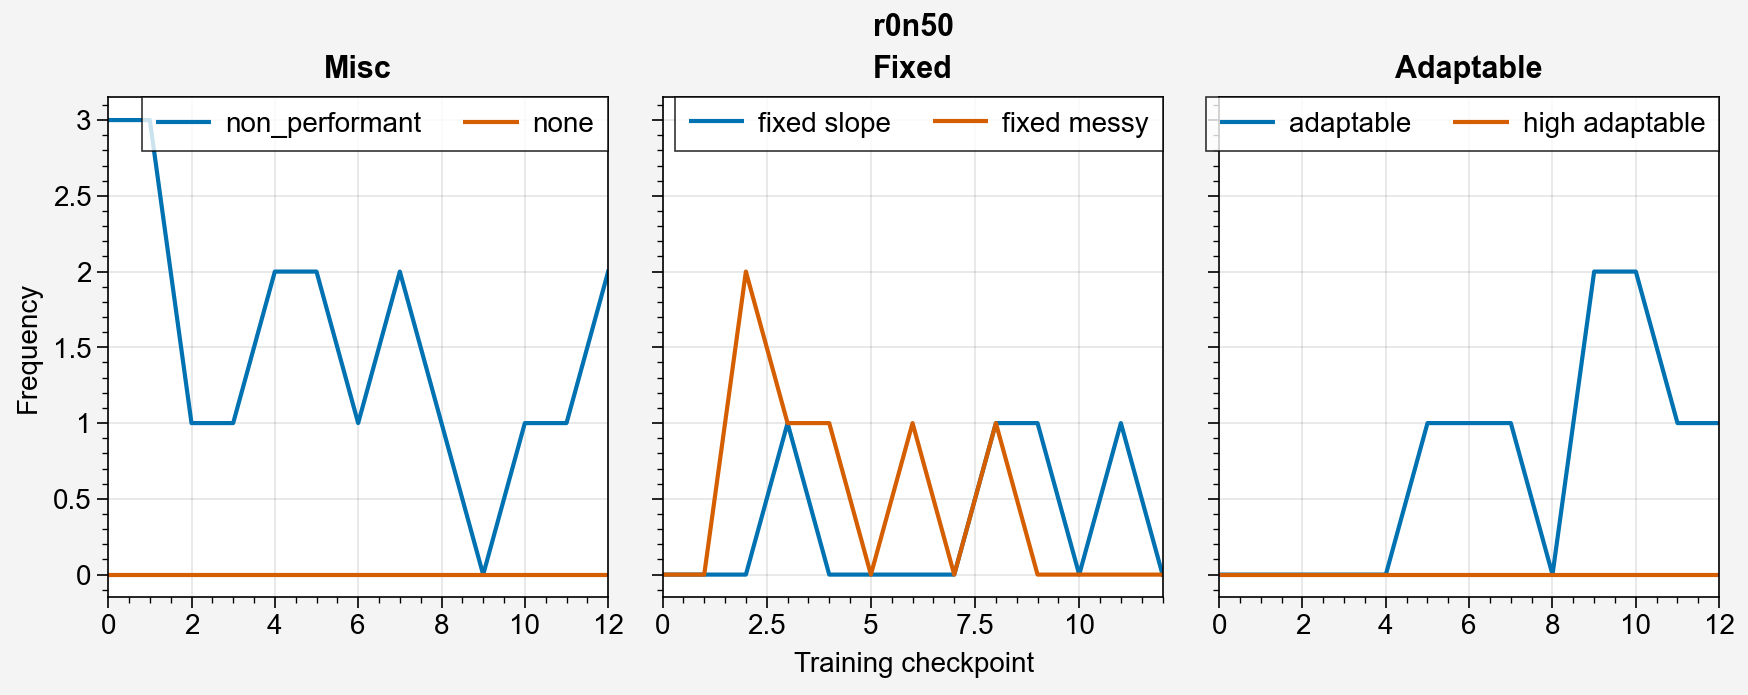

In [151]:
exp_type = 'r0n50'
fig, axs = pplt.subplots(ncols=3, sharey=True)

for i in range(len(behavior_types)):
    ax = axs[i // 2]
    ax.plot(behavior_classifications[exp_type][i], 
            label=behavior_types[i])
for i in range(3):
    axs[i].legend(loc='ur')
axs.format(xlabel='Training checkpoint', ylabel='Frequency',
          toplabels=['Misc', 'Fixed', 'Adaptable'], suptitle=exp_type)

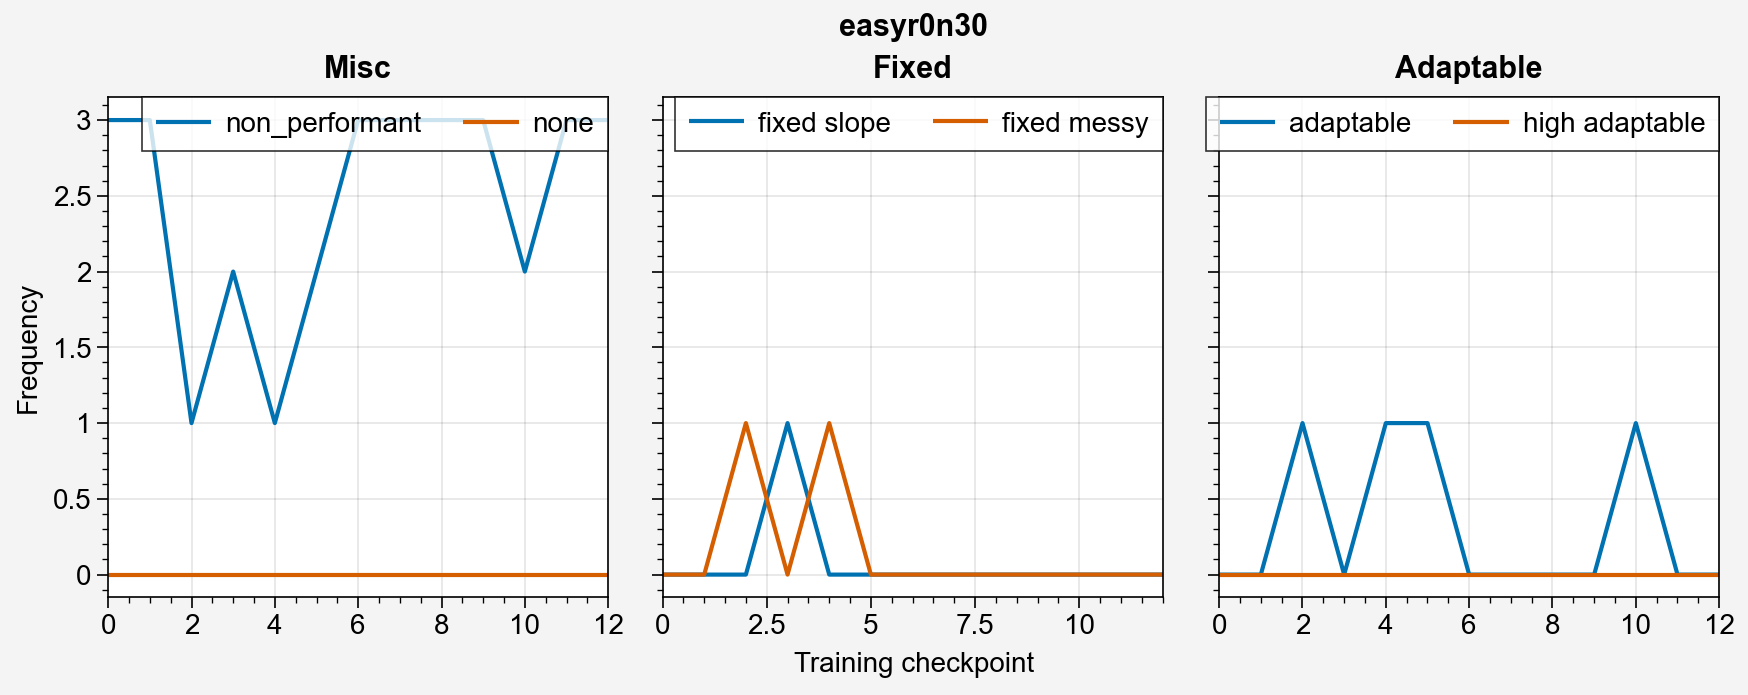

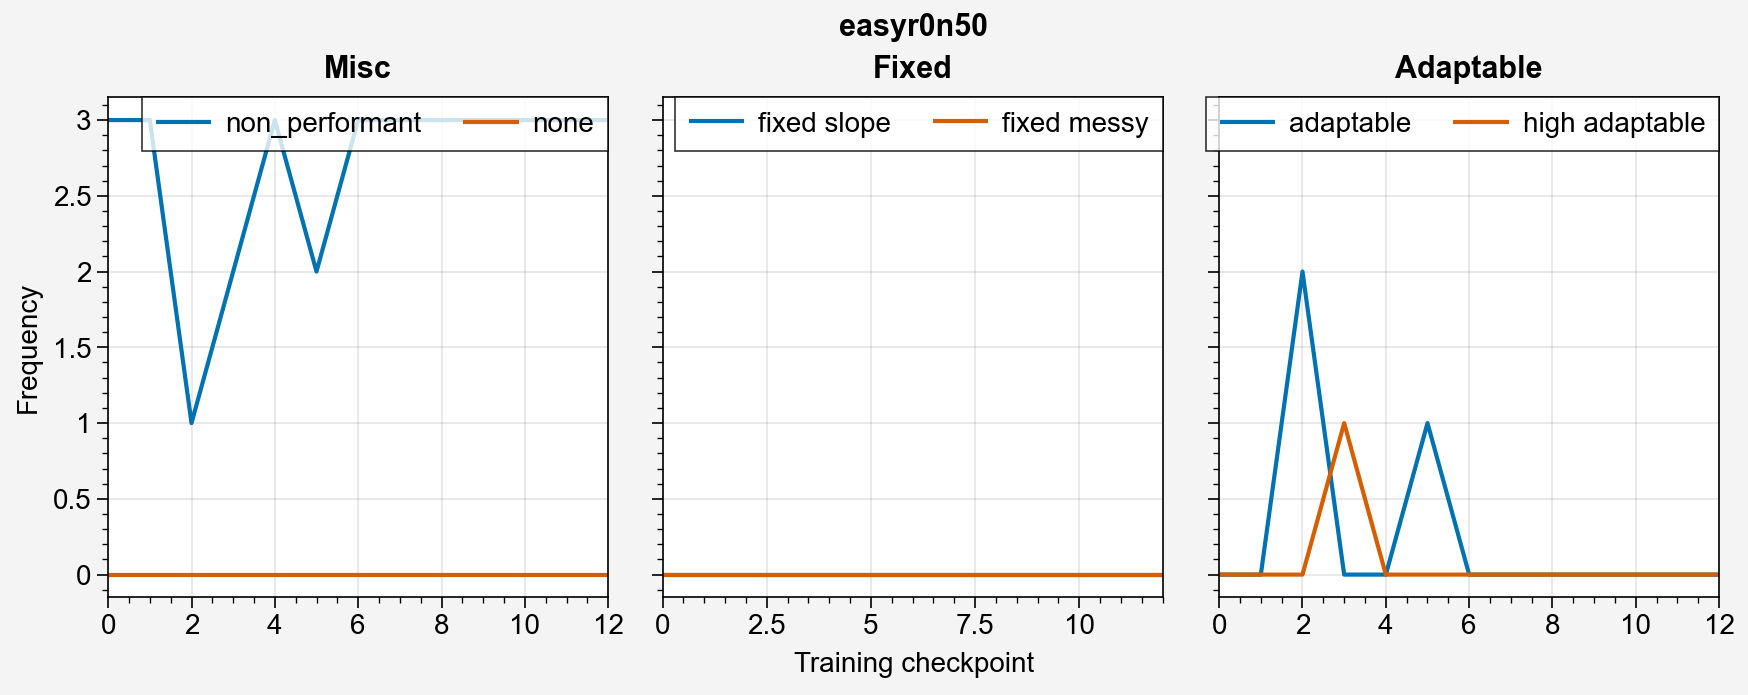

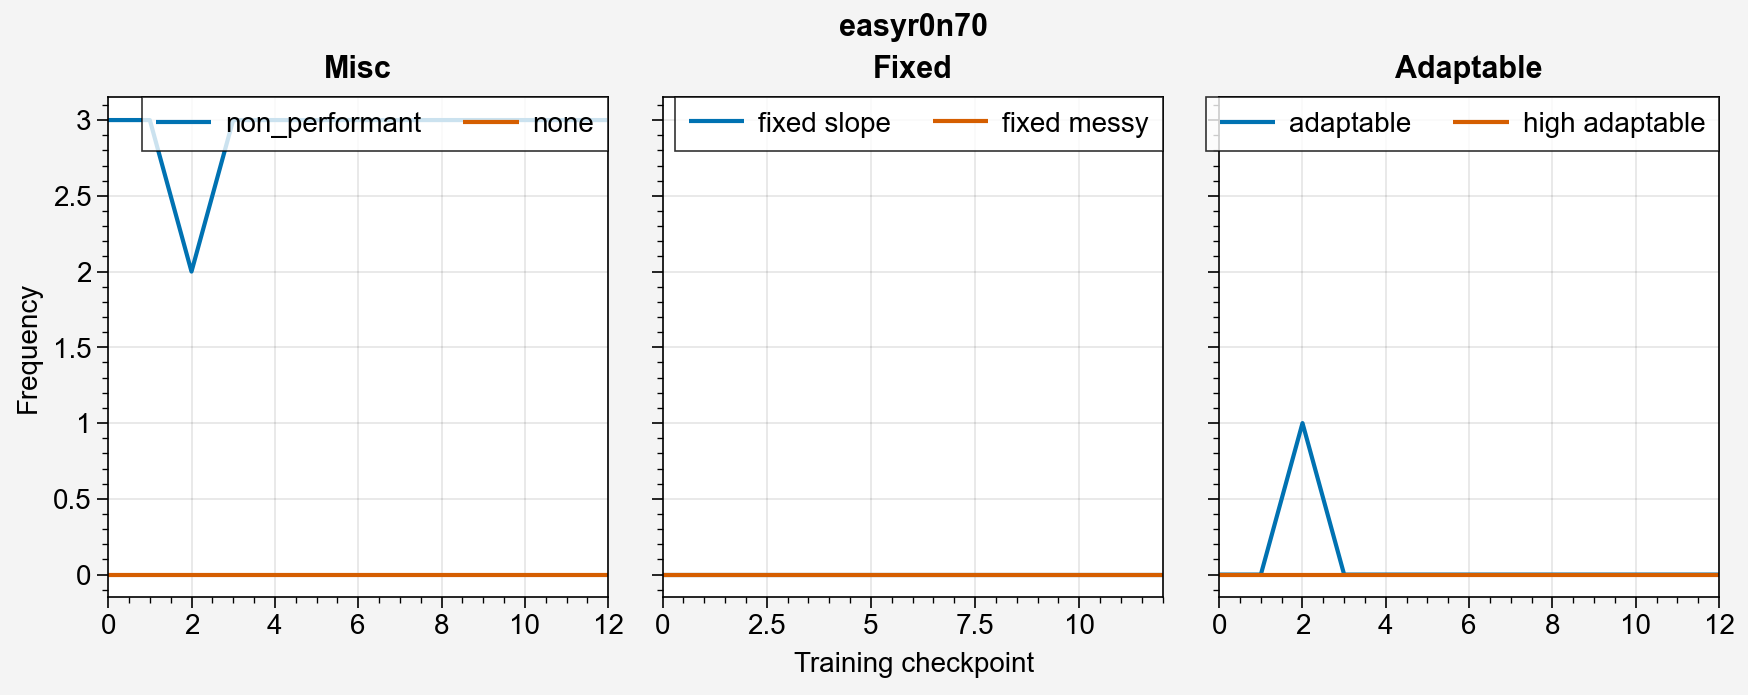

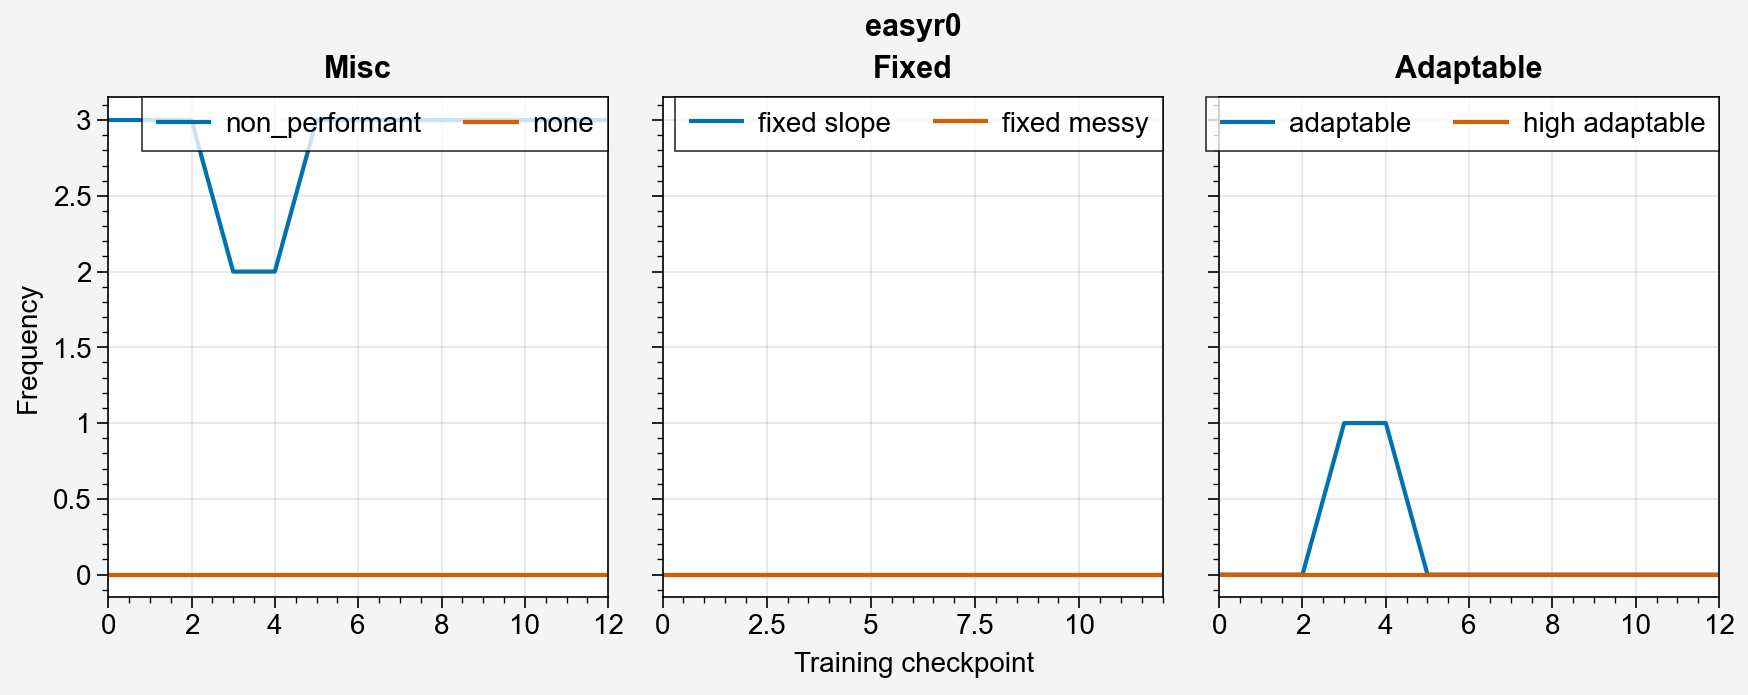

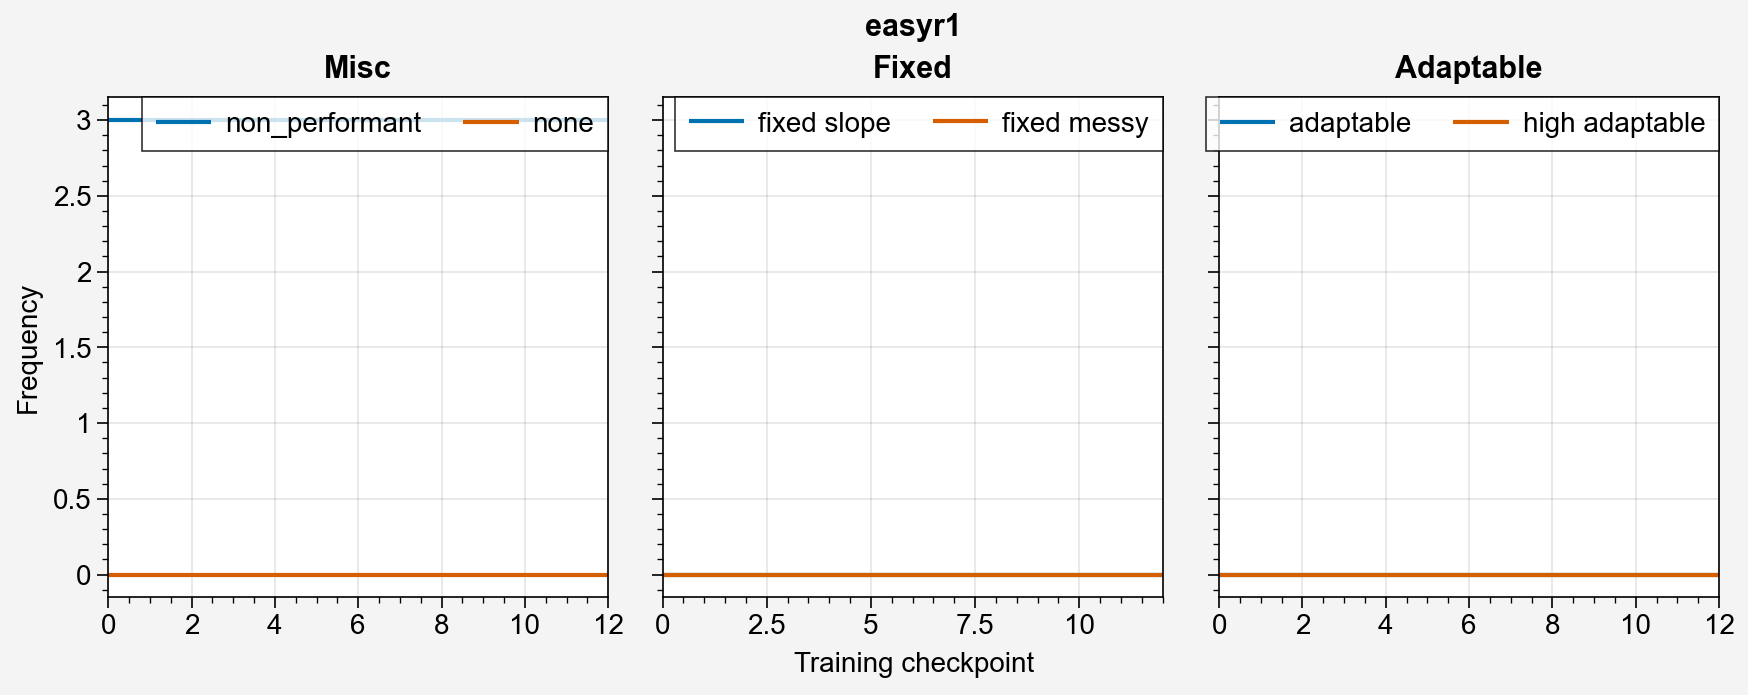

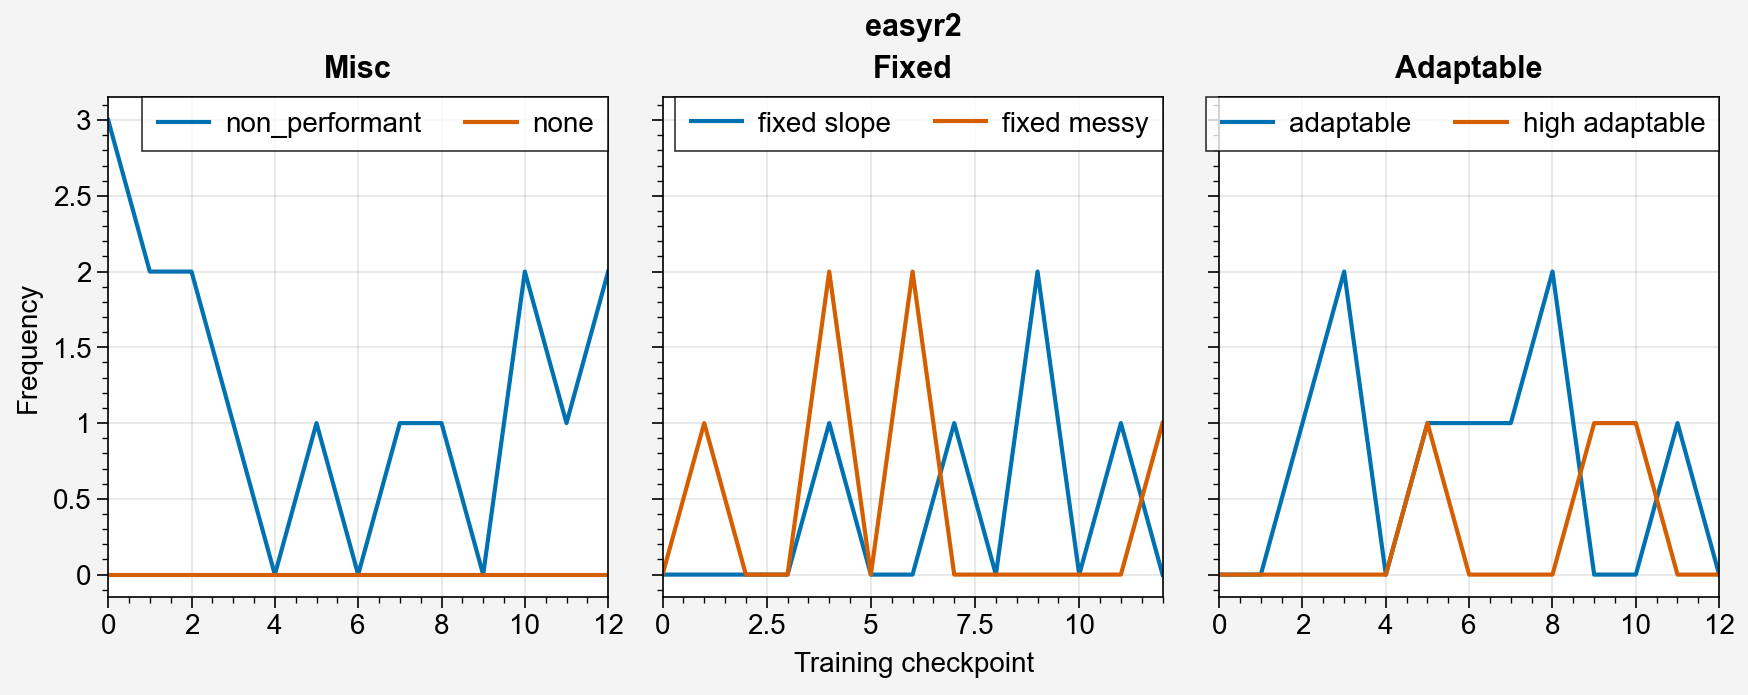

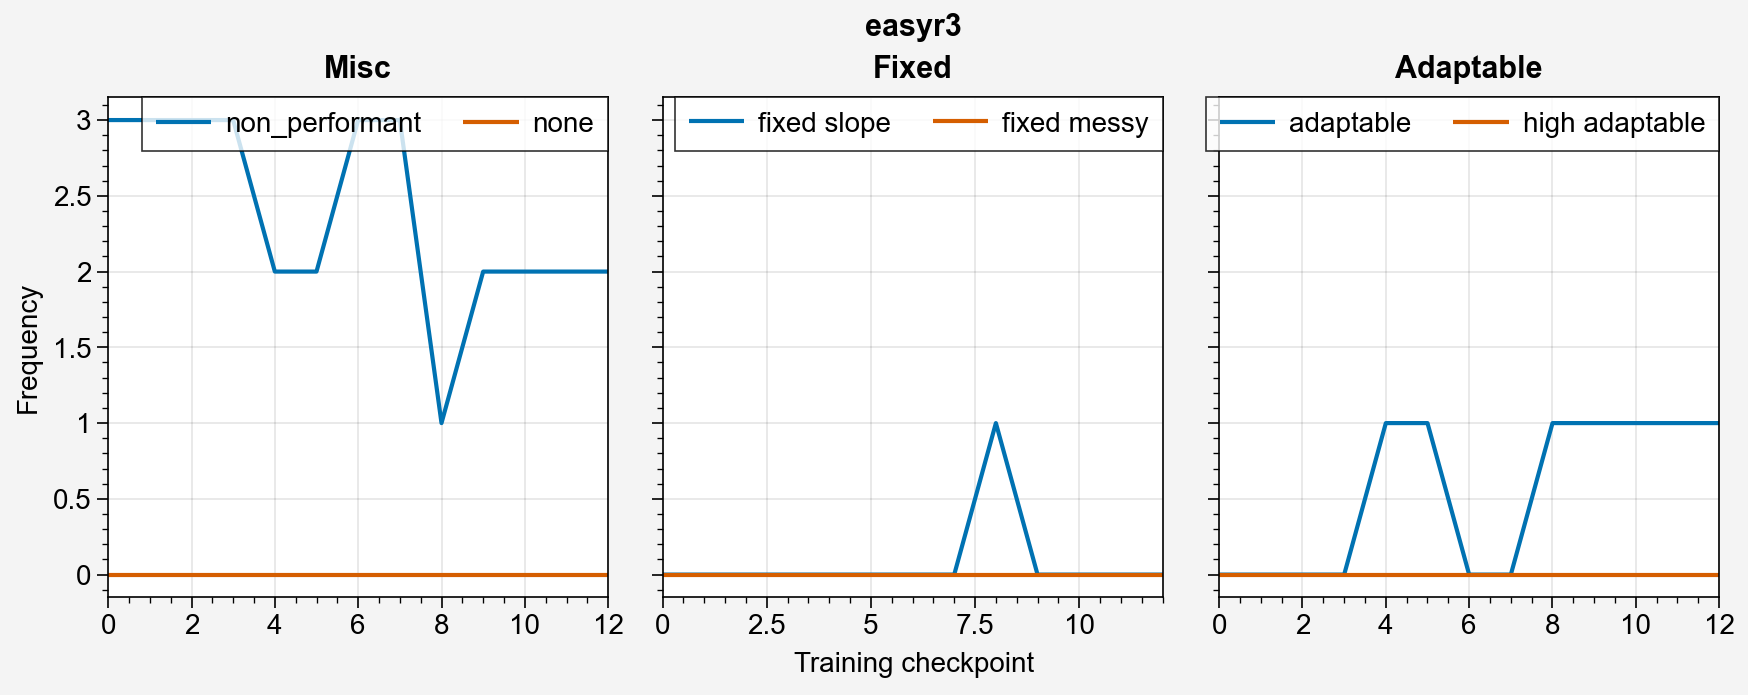

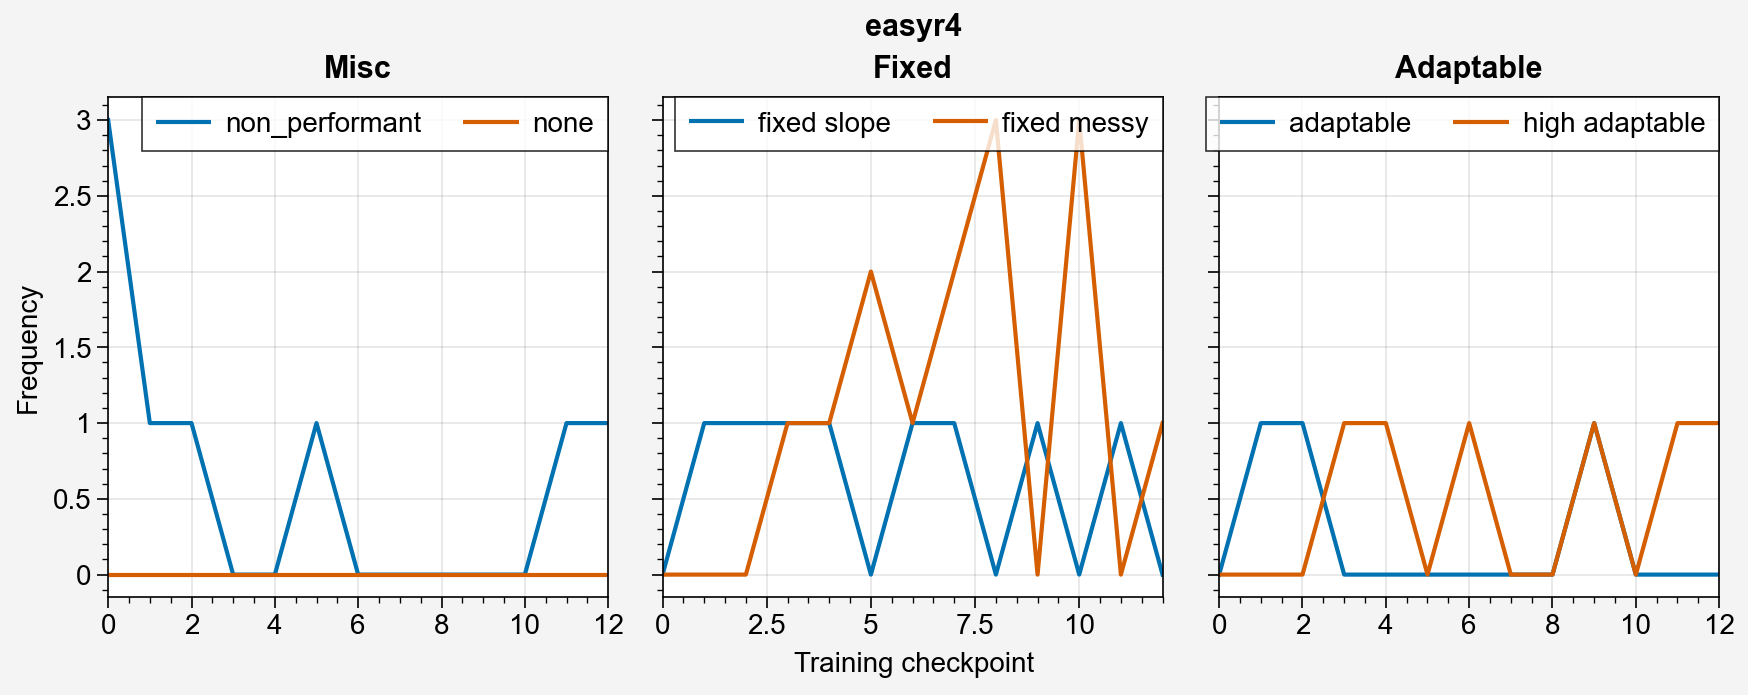

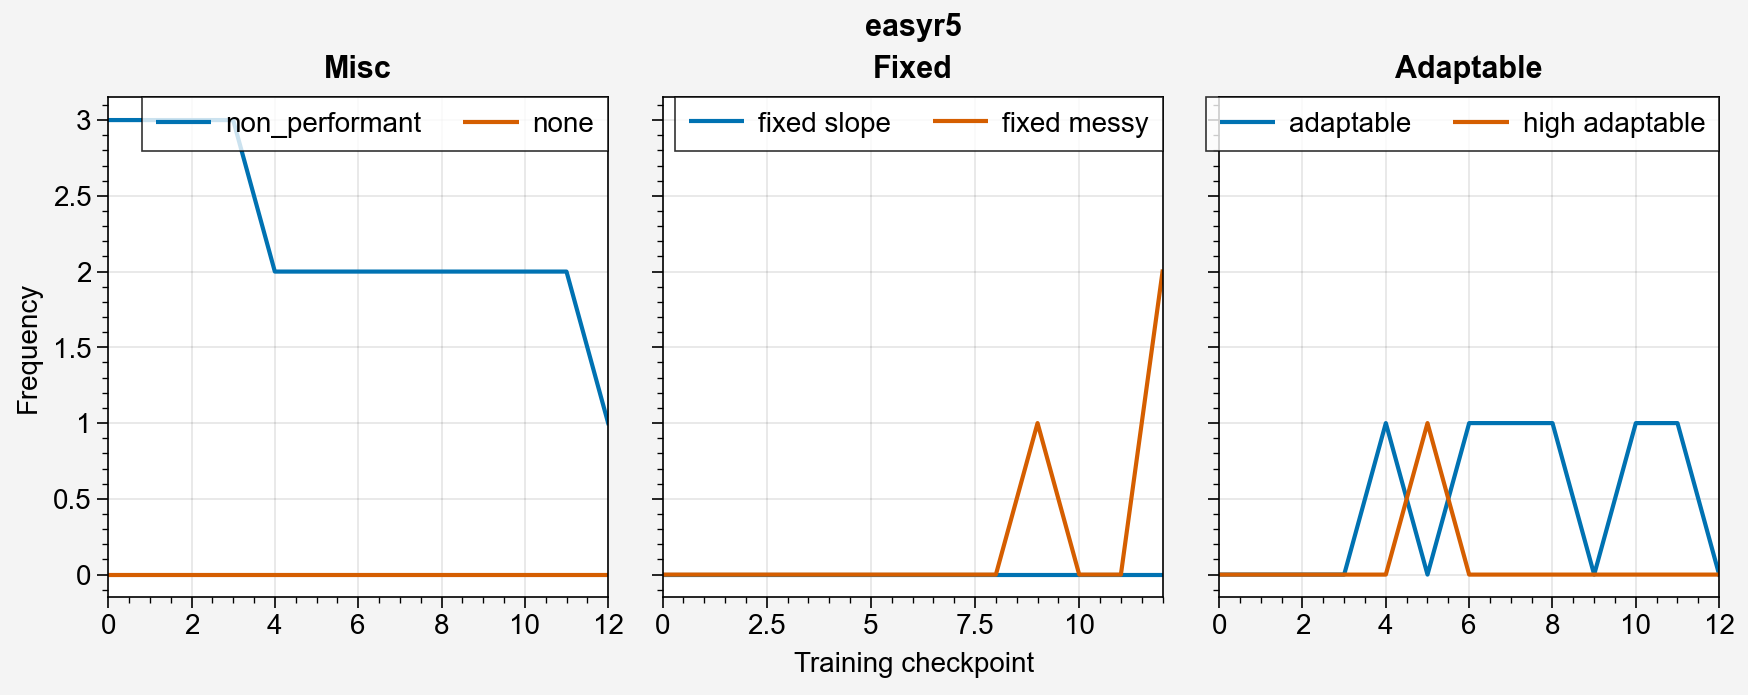

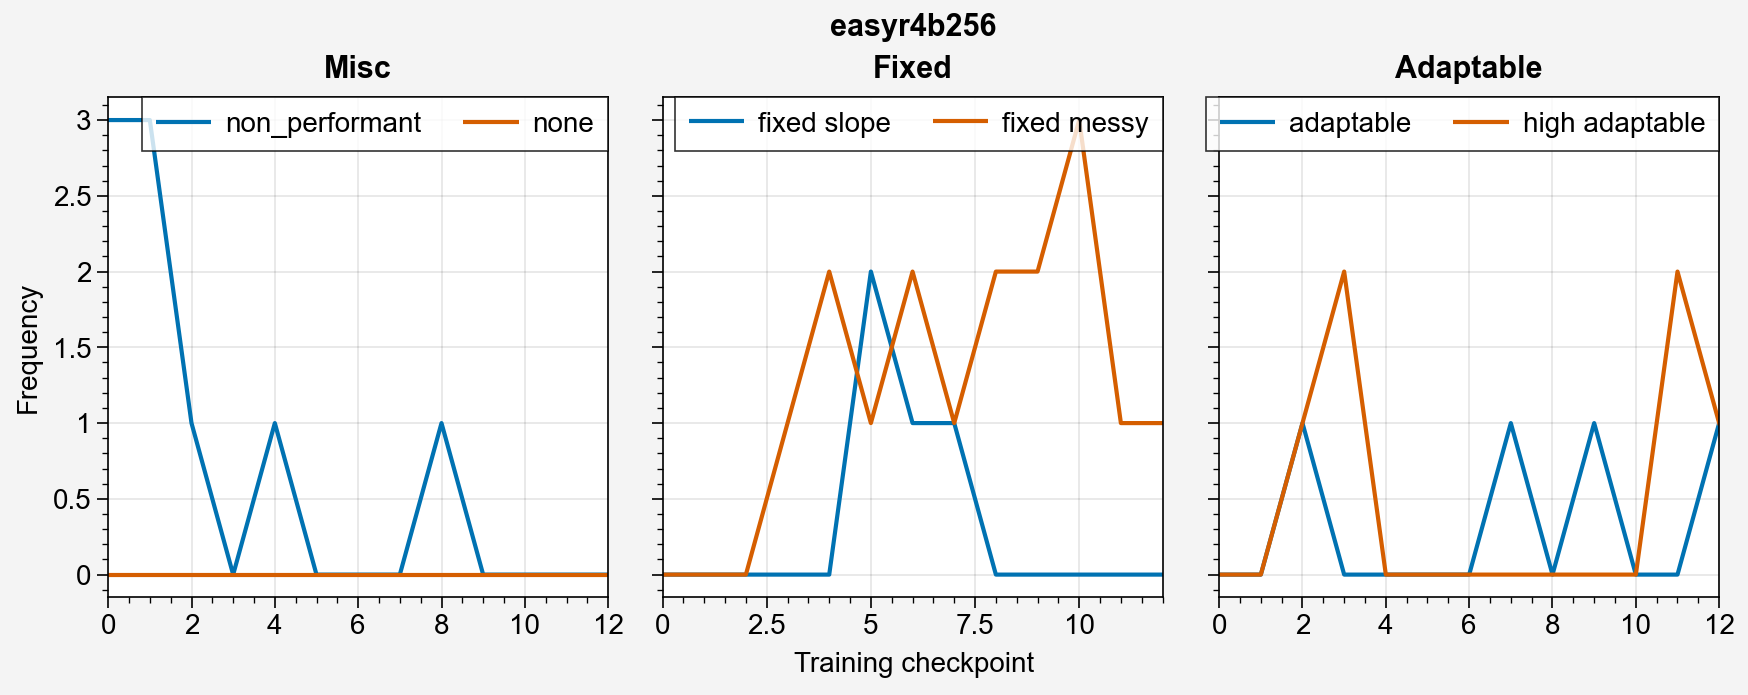

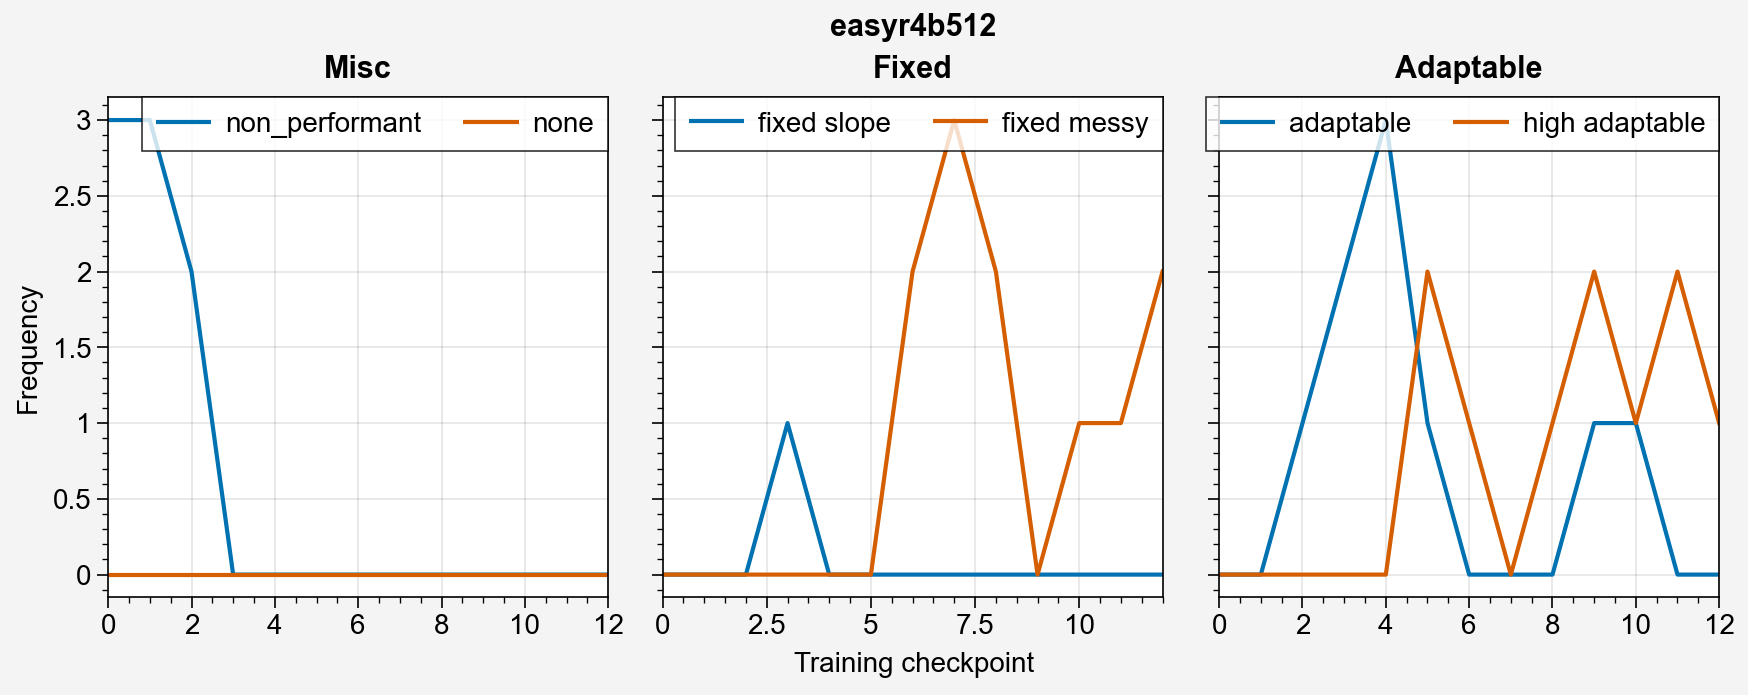

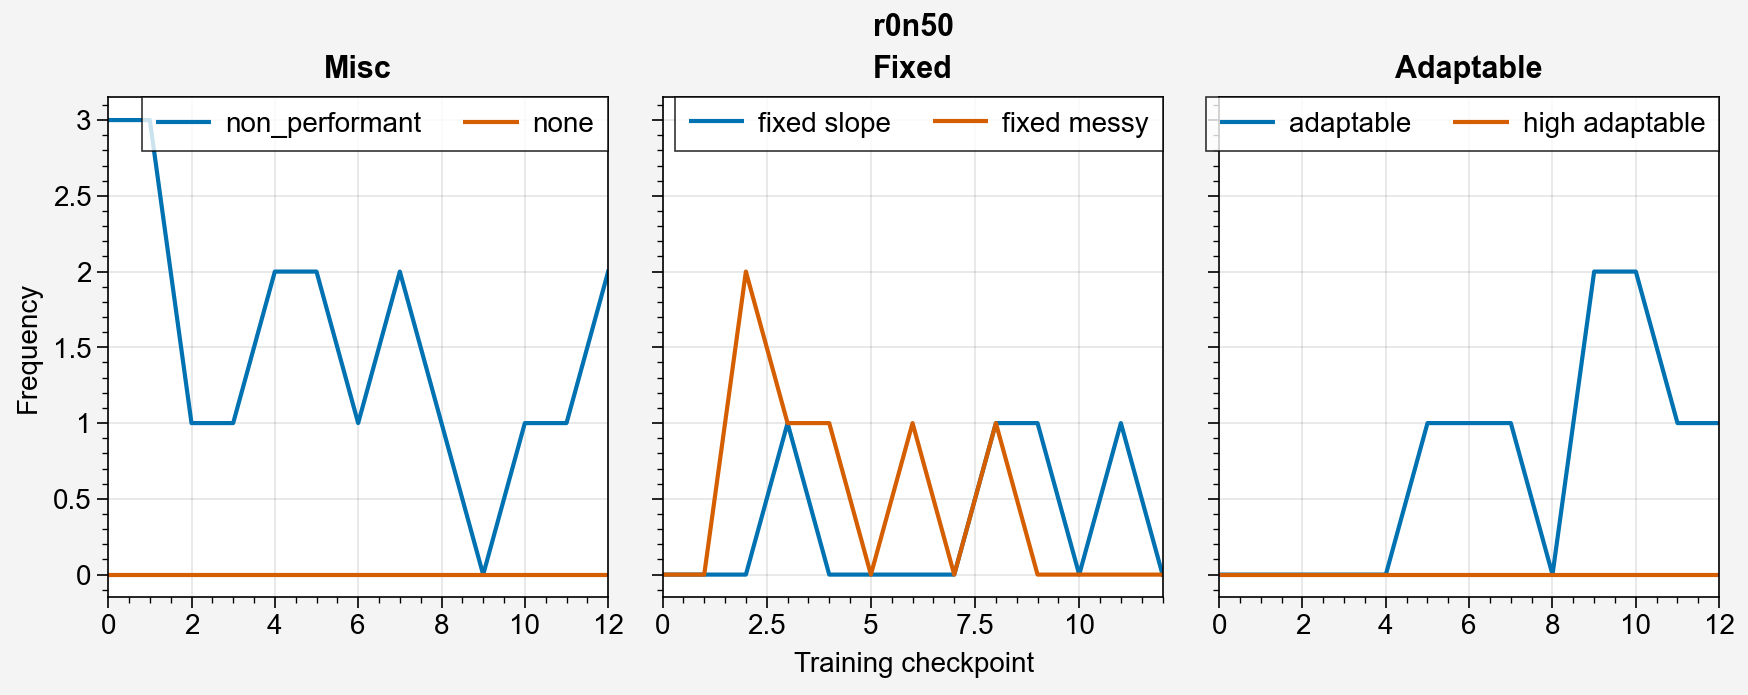

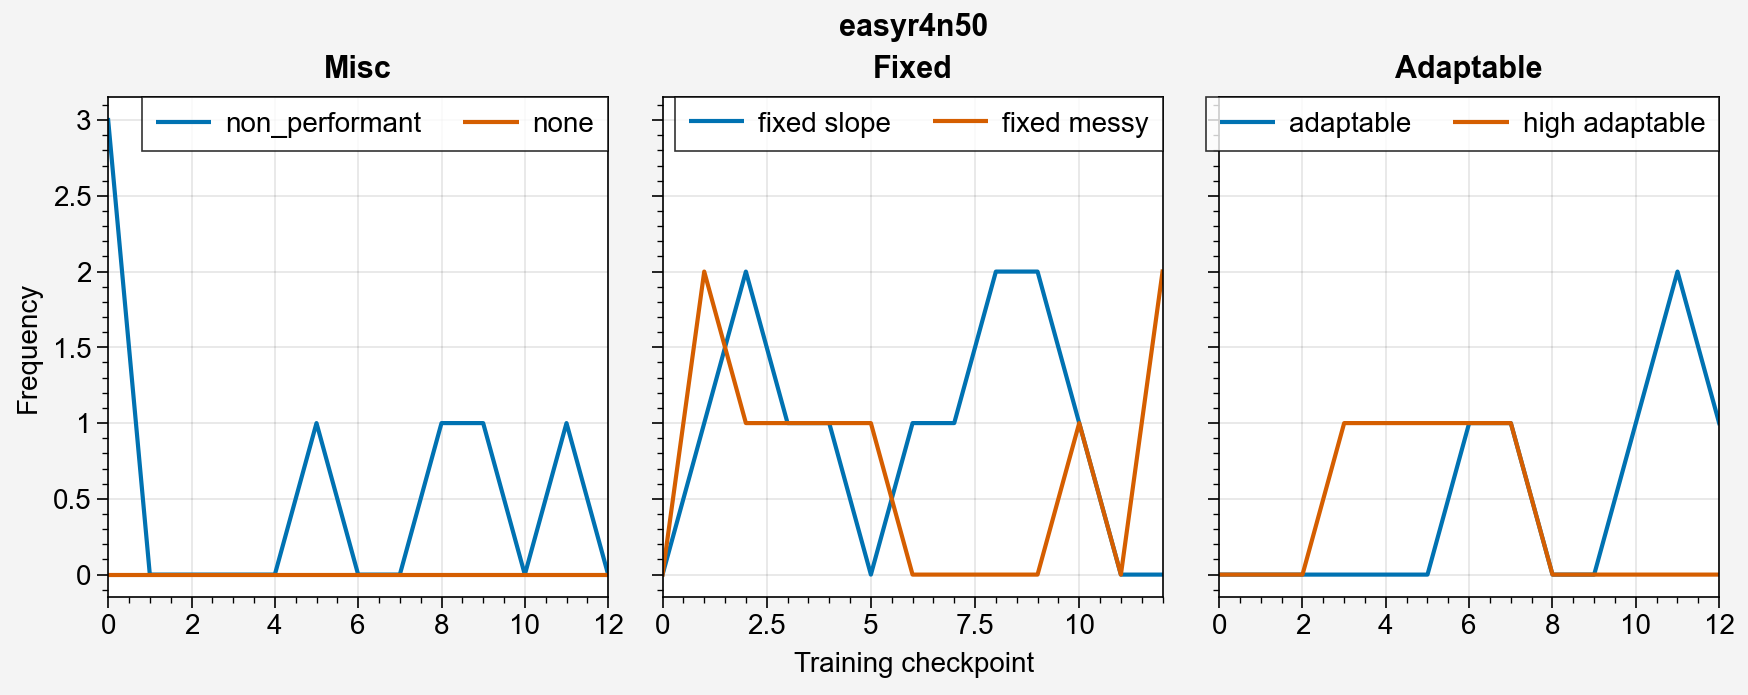

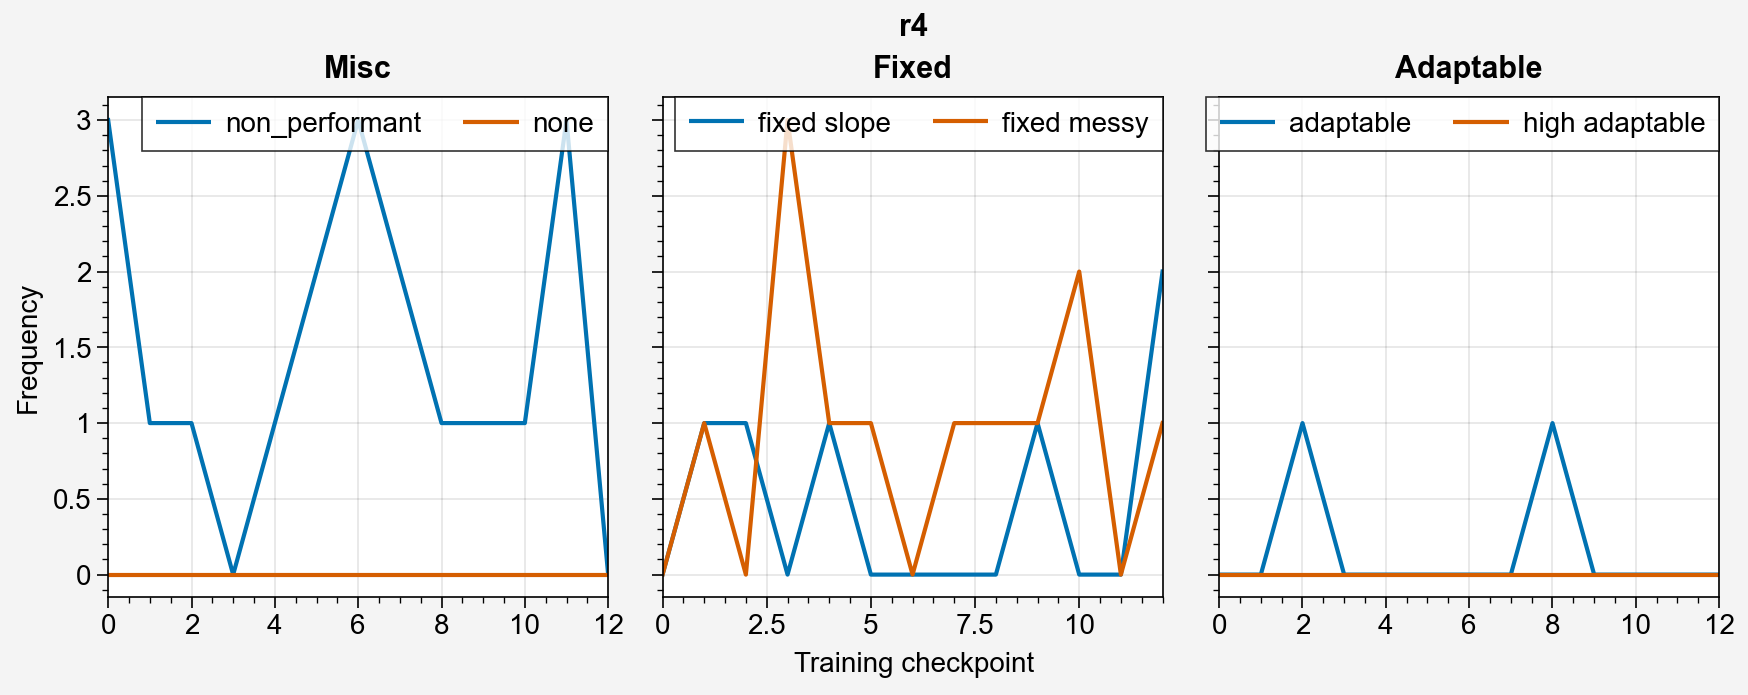

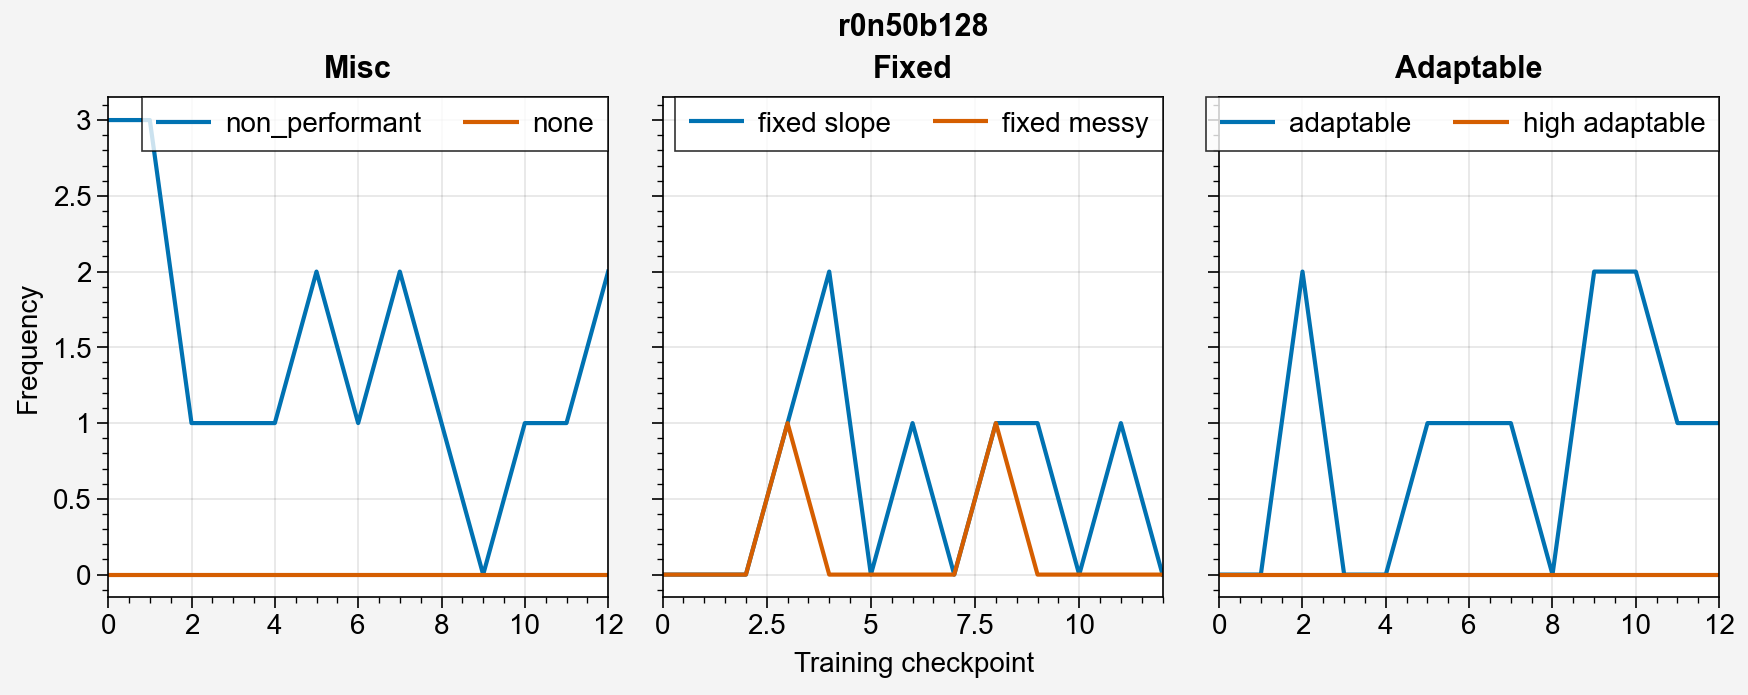

In [152]:
for exp_type in behavior_classifications:
    fig, axs = pplt.subplots(ncols=3, sharey=True)

    for i in range(len(behavior_types)):
        ax = axs[i // 2]
        ax.plot(behavior_classifications[exp_type][i], 
                label=behavior_types[i])
    for i in range(3):
        axs[i].legend(loc='ur')
    axs.format(xlabel='Training checkpoint', ylabel='Frequency',
            toplabels=['Misc', 'Fixed', 'Adaptable'], suptitle=exp_type)

In [3]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=13, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.25, 0.3, 0.35, 
                                              0.4, 0.45, 0.5, 0.55,
                                              0.6, 0.65, 0.7, 0.75, 
                                              0.8, 0.85, 0.9, 0.95, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)

fix_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)

In [37]:
env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.25, 0.3, 0.35, 
                                              0.4, 0.45, 0.5, 0.55,
                                              0.6, 0.65, 0.7, 0.75, 
                                              0.8, 0.85, 0.9, 0.95, 1.0, 0], 0]} 

In [40]:
type(env_kwargs) == list

False

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


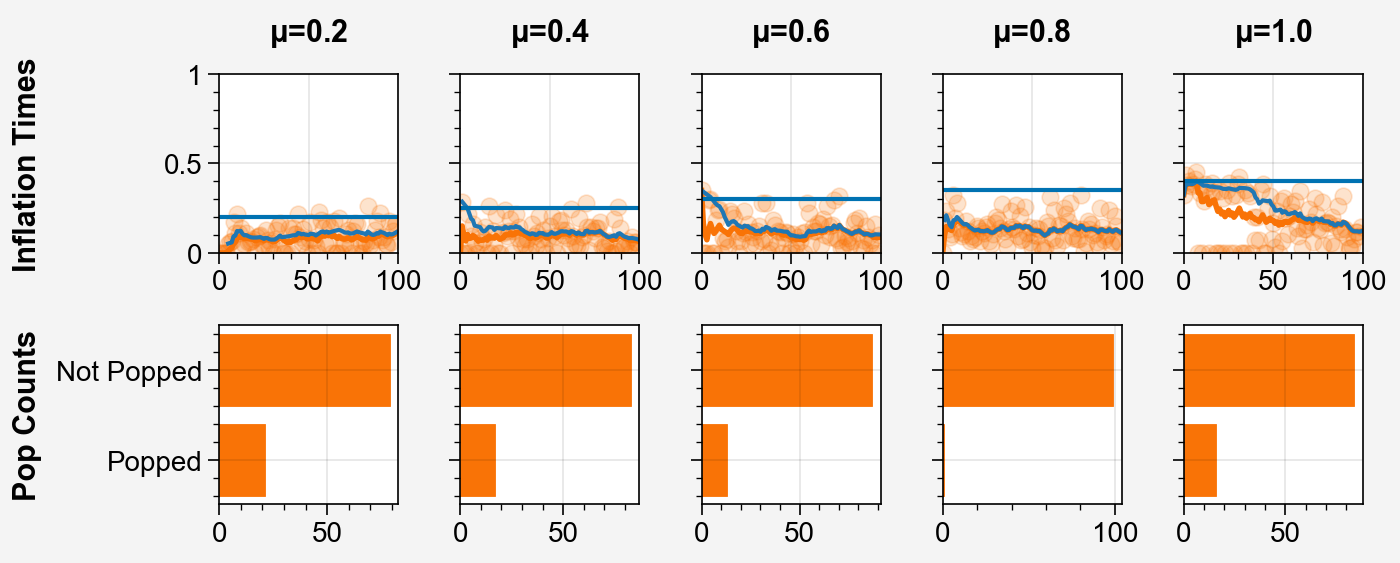

In [83]:

model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_r0n50_0/360.pt')
fixed_res = evalu(model, obs_rms)
plot_1color5fsize(fixed_res)

<a list of 3 Line2D objects>

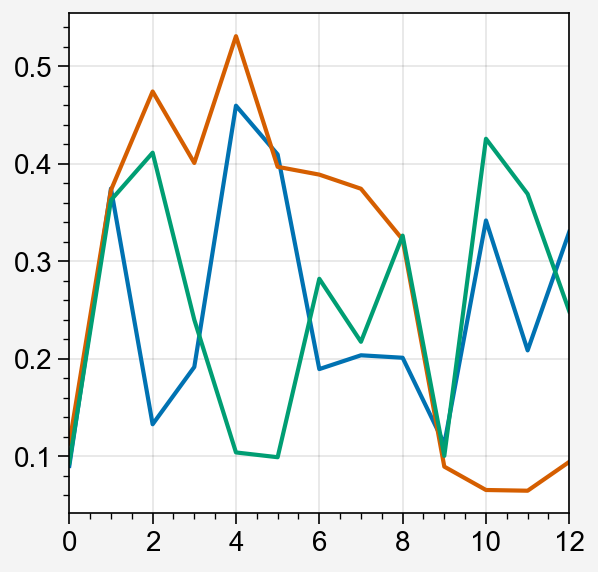

In [26]:
fig, ax = pplt.subplots()
ax.plot(np.array(max_mean).T)

In [170]:
%run model_evaluation
size = np.arange(0.2, 1.01, 0.05)

env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 100,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=13,
                seed=1,
                deterministic=False)
evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=13,
                seed=1,
                deterministic=False)

In [126]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_r0n50_0/360.pt')
res = evalu(model, obs_rms)
fixed_res = fix_size_evalu(model, obs_rms)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


In [171]:
new_res = reshape_parallel_evalu_res(res)

In [175]:
new_res['obs'][8].shape

(961, 8)

In [169]:
res['obs'][0]

(13, 988, 8)

In [166]:
len(new_res['dones'])

13